<a href="https://colab.research.google.com/github/Firojpaudel/Machine-Learning-Notes/blob/main/Practical%20Deep%20Learning%20For%20Coders/Chapter_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabular Modeling Deep Dive

In [1]:
#@ First Setting up the notebook:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [35]:
#@ Also installing the dependencies and necessary fastai's and other libraries
!pip install -Uqq fastbook waterfallcharts treeinterpreter dtreeviz
import fastbook
# fastbook.setup_book()

from fastbook import *
from fastai.callback.fp16 import *
from fastai.collab import *
from fastai.tabular.all import *
from fastai.vision.all import *
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image, display_svg, SVG
from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from dtreeviz.trees import *
warnings.simplefilter("ignore", FutureWarning)

**Objective:**

To predict the value in one column based on the values in other columns.

---

### **1. Categorical Embeddings**

#### A. Introduction



In tabular data, some columns may contain numerical data, like `age`, while others contain string values, like `sex`. The numerical data can be directly fed to the model (with some optional preprocessing), but the other columns need to be converted to numbers. Since the values in those correspond to different categories, we often call this type of variables **categorical variables**. The first type are called **continuous variables**.

<details>
<summary>
<b>Jargon: Continuous and Categorical Variables</b>
</summary>
<ul>
<li><b>Continuous variables</b> are numerical data, such as <code>age</code>, that can be directly fed to the model, since you can add and multiply them directly.</li>
<li><b>Categorical variables</b> contain a number of discrete levels, such as <code>movie ID</code>, for which addition and multiplication don’t have meaning (even if they’re stored as numbers).</li>
</ul>
</details>

##### **Example:** *Rossmann Sales Competition*
At the end of 2015, the Rossmann sales competition ran on Kaggle. Competitors were given a wide range of information about various stores in Germany and were tasked with trying to predict sales on a number of days. The goal was to help the company manage stock properly and satisfy demand without holding unnecessary inventory.

One of the gold medalists used **deep learning**, in one of the earliest examples of a state-of-the-art deep learning tabular model. Their method involved far less feature engineering based on domain knowledge than those of the other gold medalists.

The paper ["Entity Embeddings of Categorical Variables"](https://arxiv.org/abs/1604.06737) by Cheng Guo and Felix Bekhahn describes their approach:
- **Advantages of Entity Embeddings**:
  - Reduces memory usage and speeds up neural networks compared with one-hot encoding.
  - Maps similar values close to each other in the embedding space, revealing intrinsic properties of categorical variables.
  - Useful for datasets with high cardinality features where other methods tend to overfit.
  - Defines a distance measure for categorical variables, enabling visualization and clustering.

  ***

##### ***Key Insights from the Paper:***
1. **Equivalence of Embedding Layers and Linear Layers**: An embedding layer is equivalent to placing an ordinary linear layer after every one-hot encoded input layer.
2. **Embedding Weights Analysis**:
   - Transforms categorical variables into inputs that are both continuous and meaningful.
   - Embedding distances often align with intuitive or real-world distances (e.g., geographic distance for states).

---

#### B. Visualizing Embeddings

The embeddings learned can reveal patterns in categorical data:
1. **State Embeddings**: Embeddings for German states learned their relative positions based solely on sales data.
2. **Date Embeddings**: Days of the week or months close in time are also close in the embedding space.

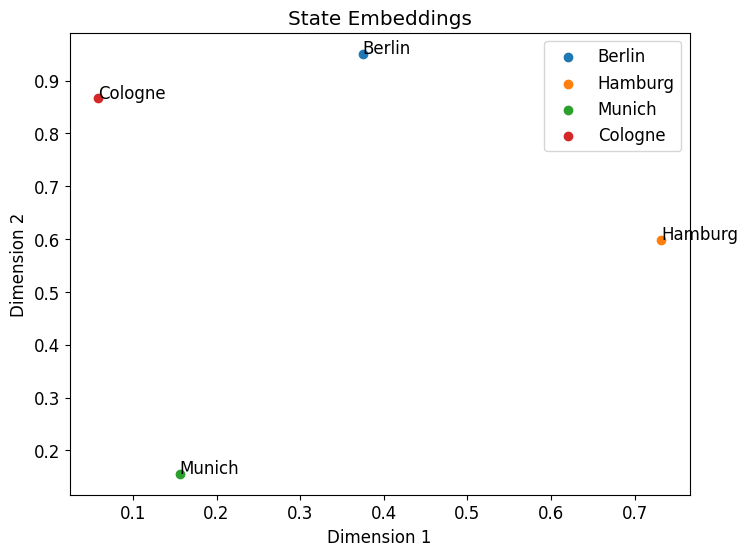

In [3]:
"Example code 1:"
import matplotlib.pyplot as plt
import numpy as np

# Simulated embedding data for states
states = ['Berlin', 'Hamburg', 'Munich', 'Cologne']
embeddings = np.random.rand(len(states), 2)

plt.figure(figsize=(8, 6))
for i, state in enumerate(states):
    plt.scatter(embeddings[i, 0], embeddings[i, 1], label=state)
    plt.text(embeddings[i, 0], embeddings[i, 1], state, fontsize=12)

plt.title('State Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

The above code simulates and visualizes embeddings for states. The scatter plot shows embeddings projected into two dimensions, and annotations indicate which state each point corresponds to. This visualization can help identify patterns, such as how similar states cluster together in the embedding space.

The next code snippet simulates embeddings for days of the week. Each point in the scatter plot represents a day, with proximity in the plot reflecting similarity in the learned embedding space. For instance, weekdays may group together, while weekends might form their own cluster.

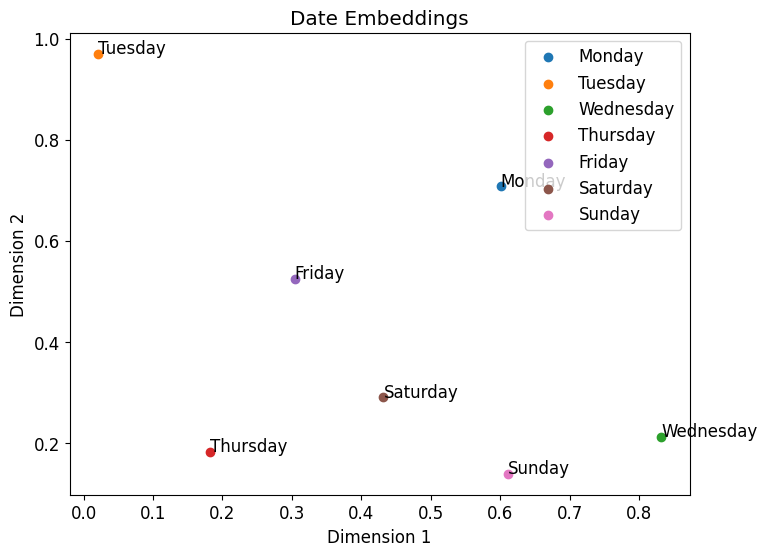

In [4]:
"Example Code 2:"
# Simulated embedding data for days of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
embeddings = np.random.rand(len(days), 2)

plt.figure(figsize=(8, 6))
for i, day in enumerate(days):
    plt.scatter(embeddings[i, 0], embeddings[i, 1], label=day)
    plt.text(embeddings[i, 0], embeddings[i, 1], day, fontsize=12)

plt.title('Date Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

---
#### C. Benefits of Embeddings


1. **Continuous Representation**: Models are better at understanding continuous variables.
2. **Efficient Integration**: Continuous embeddings can be concatenated with other continuous input data before being fed into a dense layer.

---

#### D. Real-World Application: *Google Play Recommendations*


Google’s recommendation system, as explained in the paper ["Wide & Deep Learning for Recommender Systems"](https://arxiv.org/abs/1606.07792), combines embeddings with both cross-product and neural network approaches. This hybrid system achieves state-of-the-art performance.

> Deep learning also works very well for collaborative filtering. But it is not
 always the best starting point for analyzing tabular data.

### **2. Beyond Deep Learning**

Modern machine learning can largely be summarized into two highly effective approaches:

1. **Ensembles of Decision Trees**
   - Examples: Random forests, Gradient Boosting Machines (e.g., XGBoost, LightGBM, CatBoost).
   - Best suited for structured/tabular data (e.g., datasets from database tables).
   - Advantages:
     - Faster training.
     - Easier to interpret.
     - No need for specialized GPU hardware.
     - Mature ecosystem and tooling.
     - Requires less hyperparameter tuning.
   - Tools for interpretability:
     - Identifying important features.
     - Understanding feature relationships with the target variable.
     - Explaining predictions for specific observations.

2. **Multilayered Neural Networks (Deep Learning)**
   - Examples: CNNs, RNNs, Transformers.
   - Best suited for unstructured data (e.g., images, audio, text).
   - Nearly always superior for unstructured data but may overlap with tree-based models for structured data.

> **Guideline:** Start with decision tree ensembles for structured data unless high-cardinality categorical variables or unstructured data are present.

---

#### A. Dataset for Demonstration: *Blue Book for Bulldozers*

**Problem:** Predict the auction sale price of heavy equipment based on features like usage, equipment type, and configuration.

**Source:** Supposed to be Kaggle competetion 💀

> **Problem I faced:** \
> So, the competition was over a long time ago. Now there's no other way than downloading those data manually, uploading in drive and accessing them.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# !ls /content/drive/MyDrive

In [7]:
!cp "/content/drive/MyDrive/bluebook-for-bulldozers.zip" /content/

In [8]:
#@ Extracting the zip file

zip_path = "/content/bluebook-for-bulldozers.zip"
extract_path = "/content/dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [9]:
data_path = "/content/dataset/bluebook-for-bulldozers/TrainAndValid/TrainAndValid.csv"
test_path = "/content/dataset/bluebook-for-bulldozers/Test.csv"

#@ Loading  the dataset
data_df = pd.read_csv(data_path)
test_df = pd.read_csv(test_path)

<ipython-input-9-8e1d2fd8cf28>:5: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.


In [10]:
data_df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [11]:
#@ Handling the ordinal columns

data_df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [12]:
##! Ordering

sizes= 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'

data_df['ProductSize'] = data_df['ProductSize'].astype('category')
data_df['ProductSize'].cat.set_categories(sizes, ordered= True)

,ProductSize
0,NaN
1,Medium
2,NaN
3,Small
4,NaN
...,...
412693,Mini
412694,Mini
412695,Mini
412696,Mini


In [13]:
#@ Calculating the RMLSE:

dep_var = 'SalePrice'  #dependent variable
data_df[dep_var] = np.log(data_df[dep_var])

---
#### B. Decision Trees

##### B1. Understanding Decision Tress


A decision tree consists of a sequence of binary questions that split data into distinct branches. Each split is based on a condition related to the features in the dataset. For instance, a tree can ask questions like "Is Feature A > Threshold?" and split the data accordingly. The goal is to keep splitting until we can make accurate predictions for each group.

##### B2. Steps To Train a Decision Tree

  1. Loop through each column of the dataset.
  2. For each column, evaluate all possible thresholds for splitting.
  3. Split data into two groups based on the threshold.
  4. Calculate predictions using the average target value in each group.
  5. Find the best split that minimizes prediction error.
  6. Recursively repeat the process for the resulting groups until a stopping criterion (e.g., minimum group size) is met.

---

#### C. Handling Dates

Dates need to be expanded into meaningful categorical or ordinal features (e.g., day of the week, month). This allows the decision tree to make splits based on these additional features.


In [14]:
'''
   fastai's add_datepart() function handles date. So directly using that
'''

data_df= add_datepart(data_df, 'saledate')
test_df = add_datepart(test_df, 'saledate')

"the above code is only supposed to be run once since it breaks the date to saleYear, saleMonth and so on"

/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


'the above code is only supposed to be run once since it breaks the date to saleYear, saleMonth and so on'

In [15]:
##@ Inspecting the columns which start with word "sale"

' '.join(o for o in data_df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

---
#### D. Handling Missing Data and Categoricals


Fastai provides `TabularPandas` and `TabularProcs` for handling tabular data. We use `Categorify` to convert categorical variables into numeric categories and `FillMissing` to handle missing values.


In [16]:
##@ Defining preprocessing steps
procs = [Categorify, FillMissing]

In [17]:
#@ Now we split the TrainAndValid

cond = (data_df.saleYear<2011) | (data_df.saleMonth<10)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx), list(valid_idx))

The `TabularPandas` needs to be told which columns are continuous and which are catego
rical. We can handle that automatically using the helper function `cont_cat_split`

In [18]:
cont,cat = cont_cat_split(data_df, max_card=1, dep_var=dep_var)
tabular_pandas = TabularPandas(data_df, procs, cat, cont, y_names=dep_var, splits=splits)

In [19]:
#@ Lets then test the length of these splits

len(tabular_pandas.train), len(tabular_pandas.valid)

(404710, 7988)

In [20]:
##@ Inspecting the tabular pandas object
tabular_pandas.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [21]:
##@ Inspecting  the tabular pandas object
tabular_pandas.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,963,298,43,0,0,0,59,1,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2006,11,46,16,3,320,1,1,1,1,1,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,1745,529,57,104,0,4,62,33,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,12,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2004,3,13,26,4,86,1,1,1,1,1,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,1,336,111,0,0,0,0,39,32,3,3,0,6,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,2004,2,9,26,3,57,1,1,1,1,1,1,1.077754e+09,1,1


In [22]:
tabular_pandas["SalePrice"]

,SalePrice
0,11.097410
1,10.950807
2,9.210340
3,10.558414
4,9.305651
...,...
401120,9.259130
401121,9.305651
401122,9.350102
401123,9.104980


In [23]:
##@ Saving the processed data so that we dont have to rerun everytime

save_pickle('/content/dataset/tabular_pandas.pkl', tabular_pandas)

In [24]:
#@ Loading

tabular_pandas = load_pickle('/content/dataset/tabular_pandas.pkl')

#### E. Creating Decision Trees

In [25]:
#@ First we define the independent and dependent variables

xs, y = tabular_pandas.train.xs, tabular_pandas.train.y
valid_xs, valid_y = tabular_pandas.valid.xs, tabular_pandas.valid.y

In [26]:
y = pd.Series(y)

y.fillna(0, inplace=True)

Now that our data is all numeric, and there are no missing values, we can create the decision tree

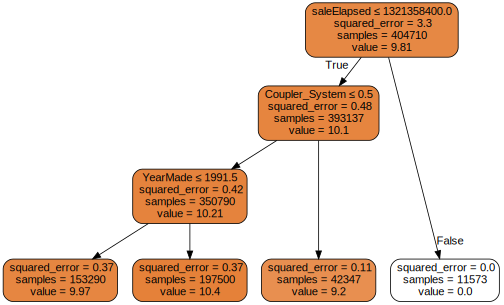

In [27]:
m = DecisionTreeRegressor(max_leaf_nodes =4)
m.fit(xs, y)

draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


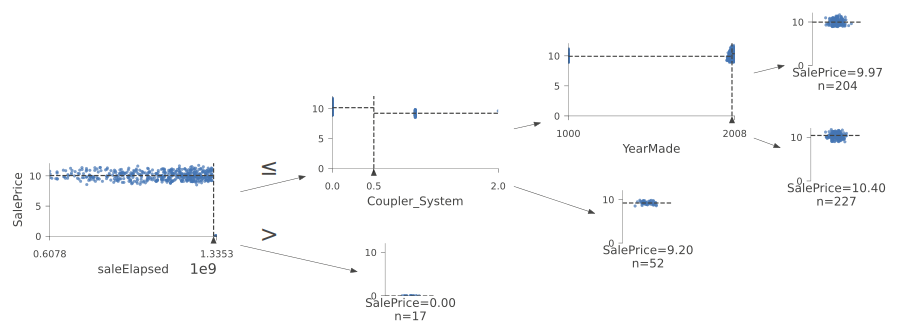

In [28]:
from dtreeviz import model

samp_idx = np.random.permutation(len(y))[:500]

viz_model = model(m, xs.iloc[samp_idx], y.iloc[samp_idx],
            feature_names=xs.columns,
            target_name=dep_var,
            class_names=list(y.unique()))
viz_model.view(fontname="DejaVu Sans", scale=1.6, label_fontsize=10, orientation="LR")

In [29]:
#@ Now using the decision tree algorithm to build a bigger tree

m = DecisionTreeRegressor()
m.fit(xs,y)

#@ Creating functions to check the root mean squared error of our model

def r_mse(pred,y):
  return round(math.sqrt(((pred-y)**2).mean()), 6)

def m_rmse(m, xs, y):
  return r_mse(m.predict(xs), y)

m_rmse(m, xs, y)

0.0

So, is the model perfect? **NO**

We need to check the validation set as well to ensure we are not, overfitting

In [30]:
m_rmse(m, valid_xs, valid_y)

8.061447

In fact its overfitting too much


In [31]:
m.get_n_leaves(), len(xs)

(315634, 404710)


The current tree seems to have almost as many leaf nodes as there are data points, which is excessive. By default, sklearn keeps splitting nodes until each leaf contains just one item. To prevent this, let's adjust the stopping rule so that each leaf node must contain at least 25 auction records.

In [38]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(xs, y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.209298, 0.271748)

And this is more acceptable


In [33]:
##@ Checking the number of leaves again
m.get_n_leaves()

12017

Also the number of leaves look reasonable

#### F. Categorical Variables

In decision trees, categorical variables can be directly used without the need for embedding layers or one-hot encoding. Here's how decision trees handle them:

1. **Binary Splits:**
   - For a categorical variable like a product code, decision trees evaluate binary splits that isolate levels of the variable into distinct groups. For example, if one product code is significantly more expensive than others, a split isolating it will be chosen.

2. **Efficiency:**
   - While it is possible to use one-hot encoding (using `pandas.get_dummies`), this approach is generally avoided as it increases computational complexity and does not necessarily improve the results.

>  **_Research Insight:_**
>  <ul>A 2019 paper by Marvin Wright and Inke König showed that ordering predictor categories in each split can reduce computational complexity without impacting model performance.</ul>


### **3. Random Forests**

#### A. Intro to Bagging

Leo Breiman introduced the concept of bagging predictors in 1994:

1. **Procedure:**
   - Randomly sample subsets of rows from the data (bootstrap replicates).
   - Train a model on each subset.
   - Aggregate predictions from all models (average or majority vote).

2. **Key Insight:**
   - Errors made by models trained on different subsets are uncorrelated. Averaging these predictions reduces the overall error.

#### B. Random Forests : Extension of Bagging

In 2001, Breiman introduced random forests, which improve on bagging by:

- Using decision trees as base models.
- Randomly selecting subsets of columns (features) at each split.

This approach results in a robust model that averages the predictions of multiple decision trees, each trained on different data subsets and splits.


#### C. Benefits of Random Forests

- **Reduced Overfitting:**
  - Random sampling of rows and columns reduces the risk of overfitting.

- **Flexibility:**
  - Works well with both classification and regression tasks.

- **Ease of Use:**
  - Hyperparameters like `max_features` and `n_estimators` are not highly sensitive, making it easy to tune.

#### D. Random Forest Implementation

In [46]:
def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(
        n_jobs=-1,
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        oob_score=True
    ).fit(xs, y)

m = rf(xs, y)

In [39]:
#@ testing  the scores again
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.209298, 0.271748)

<details>
<summary>Hyperparameters used</summary>
  <ul>
    <li>
      <b>n_estimators</b>
      <p>Number of trees in the forest. More trees improve accuracy but increase training time.</p>
    </li>
    <li>
      <b>max_samples</b>
      <p>Number of rows to sample for each tree. Defaults to using all rows but can be set to speed up training with large datasets.</p>
    </li>
    <li>
      <b>max_features</b>
      <p>Fraction of features to sample at each split. Common default is <code>0.5</code>.</p>
    </li>
    <li>
      <b>min_samples_leaf</b>
      <p>Minimum number of samples required in a leaf node. Setting this prevents overfitting.</p>
    </li>
  </ul>
</details>

#### E. Out-of-Bag (OOB) Error

- **Definition:**
  - Since each tree is trained on a random subset of data, rows not included in the training subset for a tree can be used to evaluate that tree's performance.

- **Advantages:**
  - Allows error evaluation without a separate validation set.

- **Implementation:**
  ```python
  r_mse(m.oob_prediction_, y)
  ```

- **Insight from OOB Error:**
  - If OOB error is significantly lower than validation error, additional factors (e.g., time period differences in validation set) may contribute to the discrepancy.


#### F. Validation Example

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X 

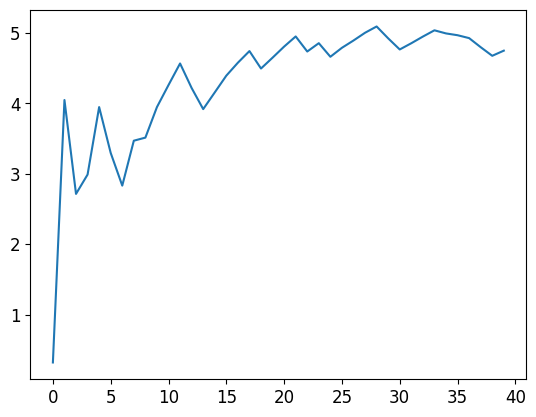

In [45]:
##@ RMSE Calculation
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
r_mse(preds.mean(0), valid_y)
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);